# Export lion patches to training dataset

In [1]:
INPUT_DIR='../../input/sea-lion/'
OUTPUT_DIR='../../output/sea-lion/02/'
SHOW_IMAGES = True

IMAGE_DIMS = (124,124,3)

#%prun print('test')
%pdb

Automatic pdb calling has been turned ON


In [2]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os

import modules.logging
from modules.logging import logger
import modules.lions as lions
from modules.utils import Timer
import modules.utils as utils

## Prepare output dataset

In [3]:
utils.mkdirs(OUTPUT_DIR, recreate=True)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
logger.info('Dir ' + OUTPUT_DIR + ' created')

x_ds = None
y_ds = None

logger.info('creating dataset')
dataset_path = OUTPUT_DIR + utils.dataset_name('lion-patches', IMAGE_DIMS)
h5file = h5py.File(dataset_path, 'w')
x_ds = h5file.create_dataset('X', (0, IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2]), maxshape=(None, IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2]), chunks=(1, IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2]), dtype='f')
y_ds = h5file.create_dataset('Y', (0, 5), maxshape=(None, 5), dtype='f')
logger.info('done')

2017-04-01 23:58:16,995 INFO Dir ../../output/sea-lion/02/ created
2017-04-01 23:58:16,997 INFO creating dataset
2017-04-01 23:58:17,003 INFO done


## Process input photos and extract lions patches to dataset

### Open csv files

In [4]:
#from MismatchedTrainImages.txt
MISMATCHED = [3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 913, 927, 946]
logger.info('loading train.csv')
train = pd.read_csv(INPUT_DIR + "Train/train.csv")

2017-04-01 23:58:17,011 INFO loading train.csv


### Process each photo

2017-04-01 23:58:17,051 INFO process all photos from train file
2017-04-01 23:58:17,056 WARNING file not found. skipping. file=../../input/sea-lion/Train/0.jpg
2017-04-01 23:58:17,058 WARNING file not found. skipping. file=../../input/sea-lion/Train/1.jpg
2017-04-01 23:58:17,060 WARNING file not found. skipping. file=../../input/sea-lion/Train/2.jpg
2017-04-01 23:58:17,061 WARNING skipping mismatched train_id 3
2017-04-01 23:58:17,063 WARNING file not found. skipping. file=../../input/sea-lion/Train/4.jpg
2017-04-01 23:58:17,065 WARNING file not found. skipping. file=../../input/sea-lion/Train/5.jpg
2017-04-01 23:58:17,067 WARNING file not found. skipping. file=../../input/sea-lion/Train/6.jpg
2017-04-01 23:58:17,068 WARNING skipping mismatched train_id 7
2017-04-01 23:58:17,070 WARNING file not found. skipping. file=../../input/sea-lion/Train/8.jpg
2017-04-01 23:58:17,072 WARNING skipping mismatched train_id 9
2017-04-01 23:58:17,075 WARNING file not found. skipping. file=../../input/

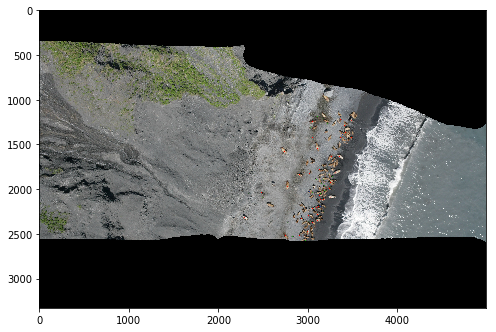

2017-04-01 23:58:19,061 INFO > [started] generating image patches. rows=16; cols=12...


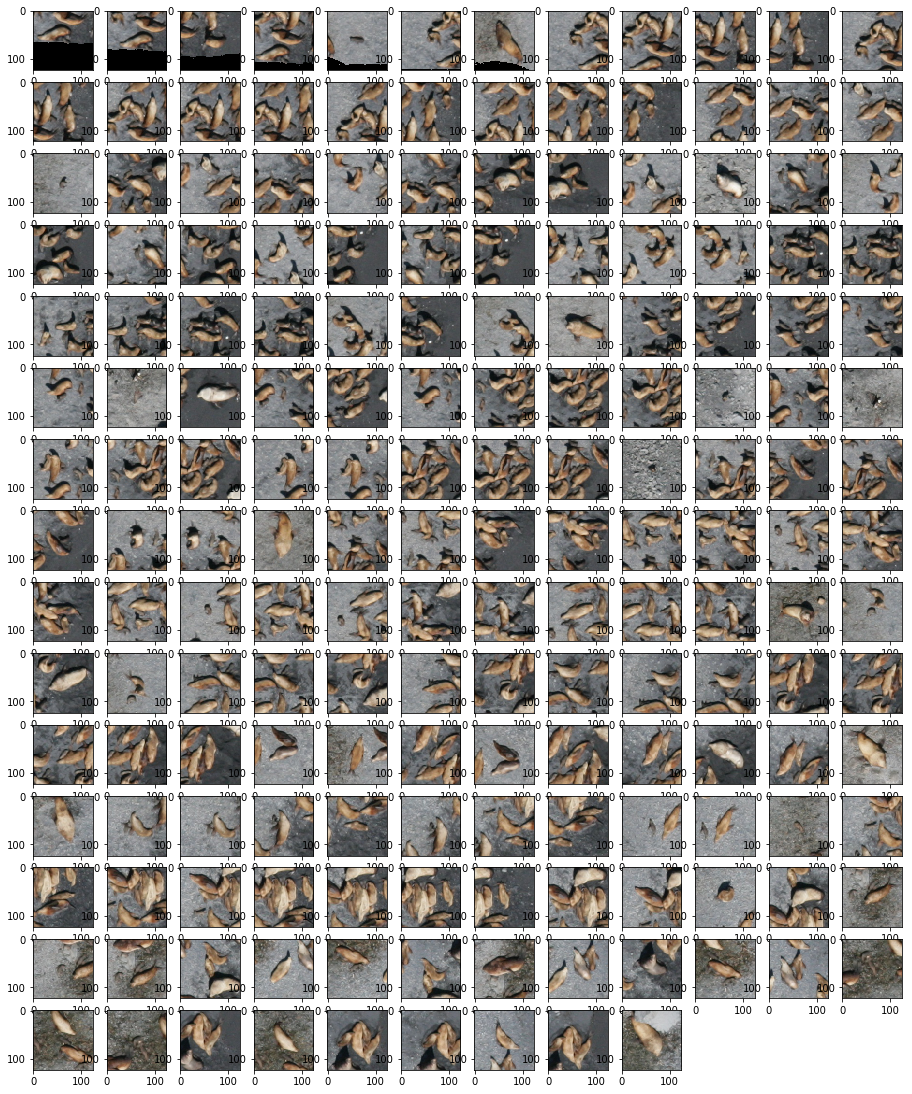

2017-04-01 23:58:32,761 INFO > [done]    generating image patches. rows=16; cols=12 (13700.126 ms)
2017-04-01 23:58:32,763 INFO total animals found: 177
2017-04-01 23:58:32,788 INFO detected classes count
2017-04-01 23:58:32,790 INFO [ 15.   0.  85.  18.  59.]
2017-04-01 23:58:32,791 INFO -----
2017-04-01 23:58:32,793 INFO expected classes count
2017-04-01 23:58:32,795 INFO Pandas(Index=41, train_id=41, adult_males=15, subadult_males=0, adult_females=85, juveniles=18, pups=59)
2017-04-01 23:58:32,796 INFO -----
2017-04-01 23:58:32,798 INFO errors per class
2017-04-01 23:58:32,799 INFO [ 0.  0.  0.  0.  0.]
2017-04-01 23:58:32,801 INFO acum errors per class
2017-04-01 23:58:32,802 INFO [ 0.  0.  0.  0.  0.]
2017-04-01 23:58:32,803 INFO -----
2017-04-01 23:58:32,804 INFO acum detected classes count
2017-04-01 23:58:32,806 INFO [ 15.   0.  85.  18.  59.]
2017-04-01 23:58:32,808 INFO > [done]    processing photo ../../input/sea-lion/Train/41.jpg (15676.125 ms)
2017-04-01 23:58:32,810 INFO 

In [5]:
logger.info('process all photos from train file')
count = 0
total_errors = np.zeros(5)
total_classes = np.zeros(5)
for row in train.itertuples():
    #load images
    train_id = row[1]
    image_raw_file = INPUT_DIR + 'Train/'+ str(train_id) +'.jpg'
    image_dotted_file = INPUT_DIR + 'TrainDotted/'+ str(train_id) +'.jpg'

    if(train_id in MISMATCHED):
        logger.warning('skipping mismatched train_id ' + str(train_id))
        continue
    
    if(not os.path.isfile(image_raw_file)):
        logger.warning('file not found. skipping. file=' + image_raw_file)
        continue
        
    t = Timer('processing photo ' + image_raw_file)
    image_raw = cv2.imread(image_raw_file)
    image_dotted = cv2.imread(image_dotted_file)
    
    classes_count = lions.export_lions(image_raw, image_dotted, x_ds, y_ds, IMAGE_DIMS, debug=True)
    logger.info('detected classes count')
    logger.info(str(classes_count))
    logger.info('-----')
    logger.info('expected classes count')
    logger.info(str(row))
    logger.info('-----')
    logger.info('errors per class')
    error = np.subtract(row[2:], classes_count)
    logger.info(str(error))
    logger.info('acum errors per class')
    total_errors = np.add(total_errors, np.absolute(error))
    logger.info(str(total_errors))
    logger.info('-----')
    logger.info('acum detected classes count')
    total_classes = np.add(total_classes, classes_count)
    logger.info(str(total_classes))
    t.stop()
    
    count = count + 1
    if(count>=1): break

logger.info('ERRORS PER CLASS')
logger.info(str(total_errors))
        
h5file.close()

### Validate dataset